### combine data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!mkdir -p "LGP_input/datasets"

In [3]:
import splitfolders
train_src = "LGP_input/Images"

splitfolders.ratio(train_src, output="LGP_output/datasets/asl_alphabet",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

In [4]:
train_dir2 = 'LGP_output/datasets/asl_alphabet/train'
val_dir2 = 'LGP_output/datasets/asl_alphabet/val'
test_dir2  = 'LGP_output/datasets/asl_alphabet/test'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
target_size = (128,128) # dataset pic = 200x200

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator2 = train_datagen.flow_from_directory(
        train_dir2,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator2 = val_datagen.flow_from_directory(
        val_dir2,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

test_generator2 = test_datagen.flow_from_directory(
        test_dir2,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 19202 images belonging to 27 classes.
Found 2388 images belonging to 27 classes.
Found 2427 images belonging to 27 classes.


In [15]:
labels = list(train_generator2.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing']


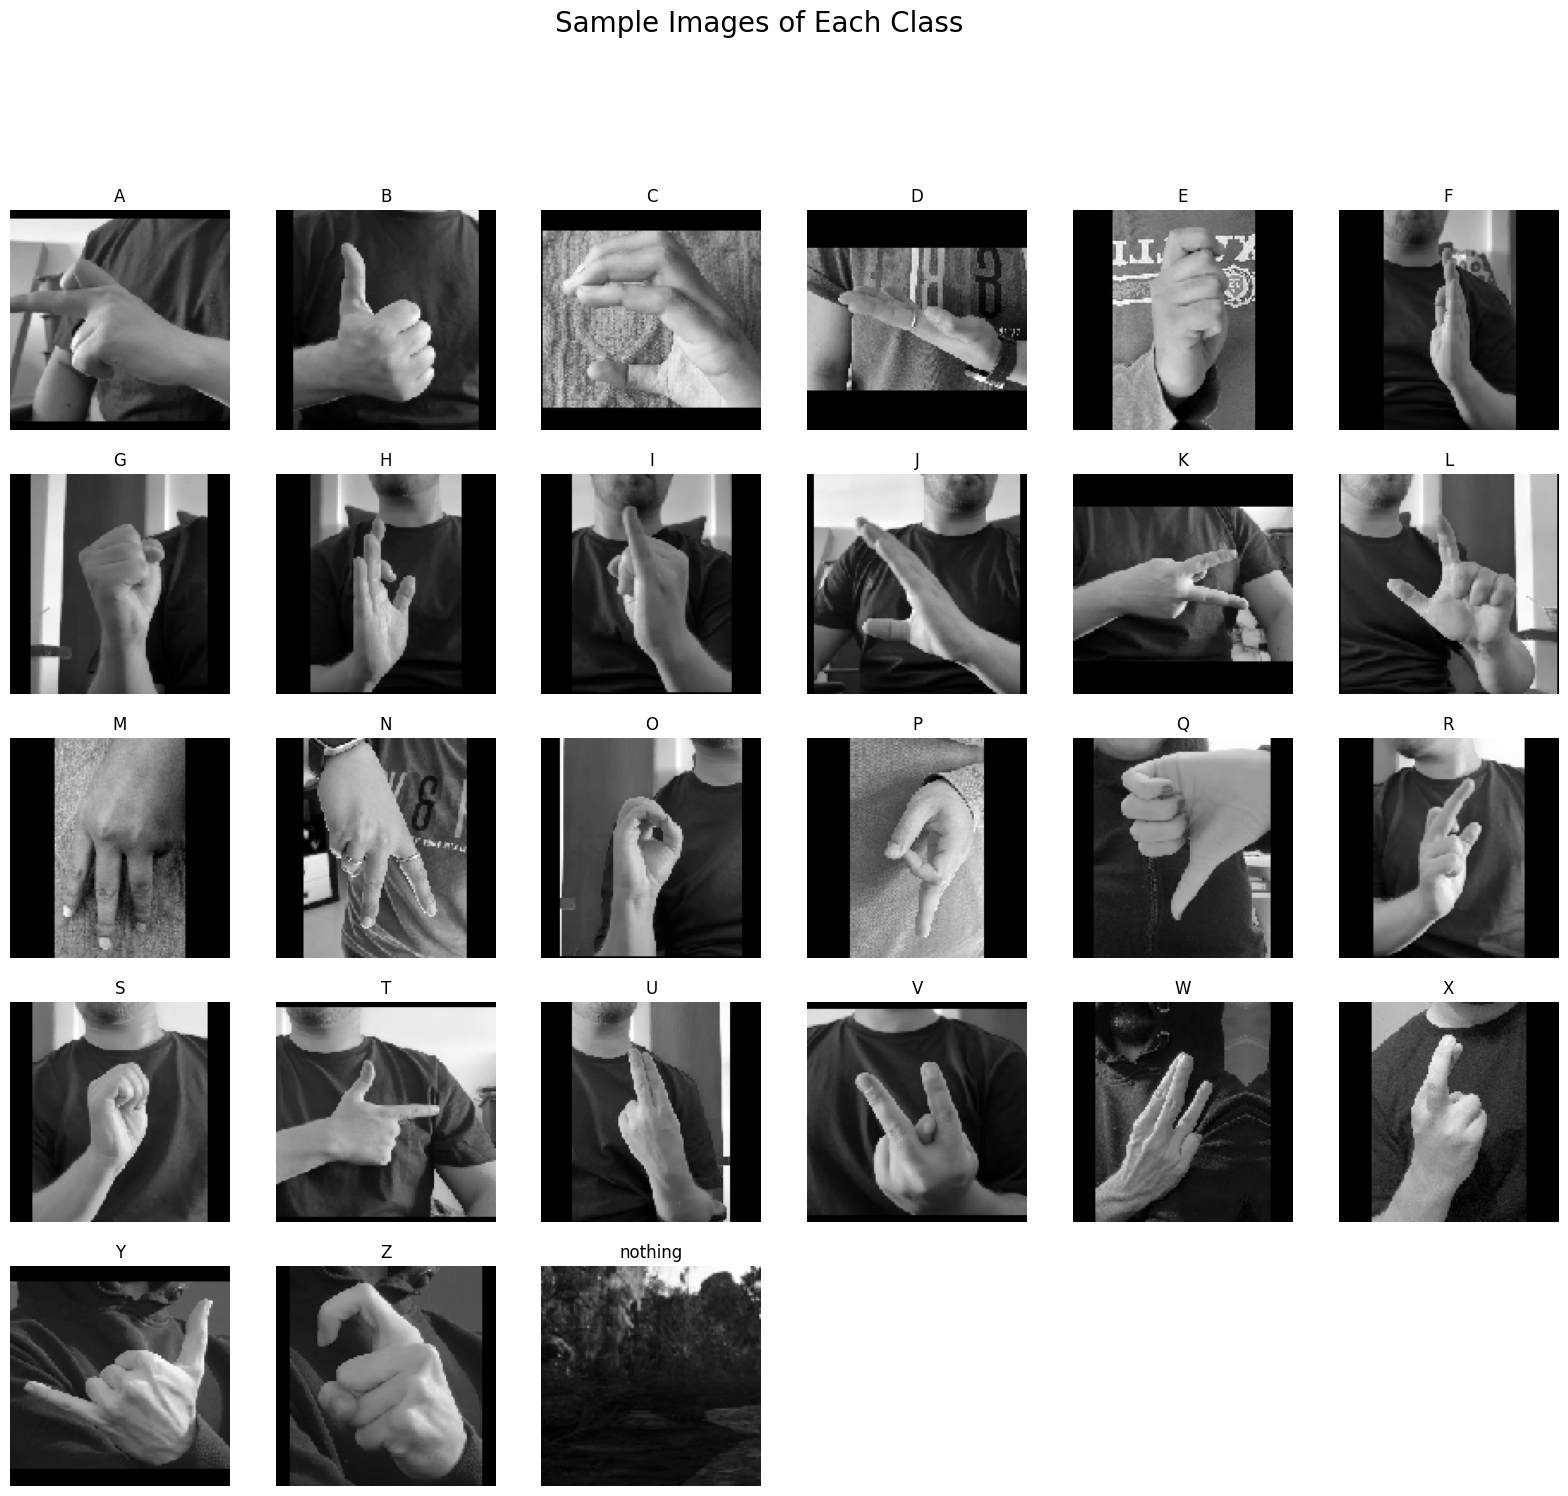

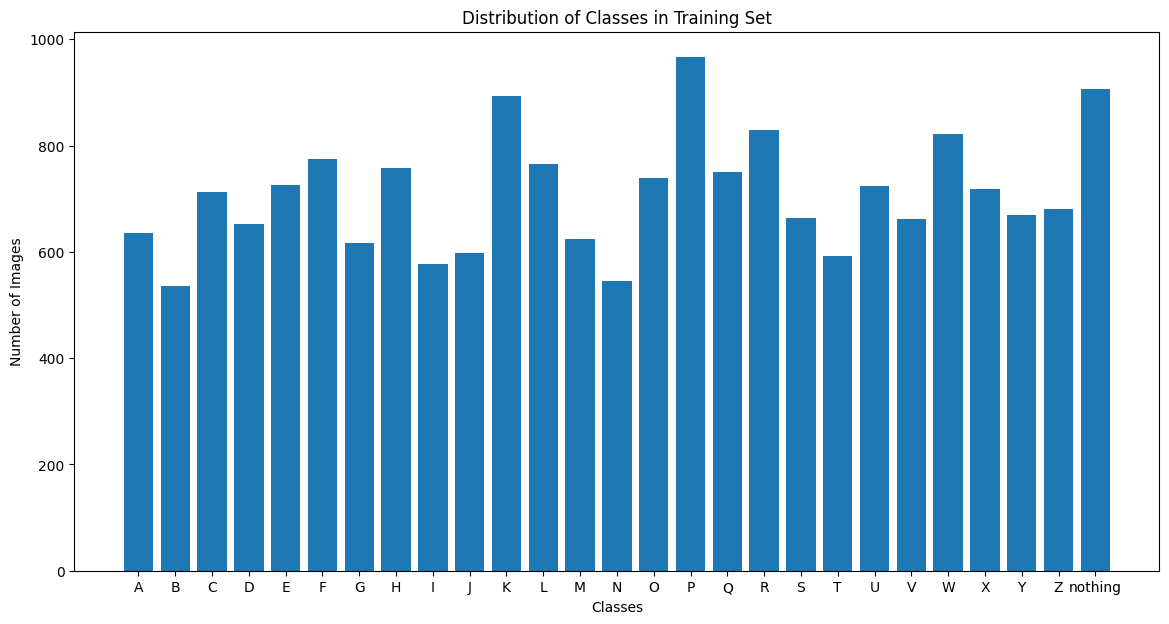

In [7]:

from collections import Counter
# Create the indices_to_class mapping
class_indices = train_generator2.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}
num_classes = len(class_indices)

# Collect one example per class
examples_per_class = {}
while len(examples_per_class) < num_classes:
    images, labels = next(train_generator2)
    labels = np.argmax(labels, axis=1)
    for class_index in range(num_classes):
        if class_index not in examples_per_class:
            idx = np.where(labels == class_index)[0]
            if len(idx) > 0:
                examples_per_class[class_index] = images[idx[0]]

# Plotting a sample of each letter
plt.figure(figsize=(20, 20))
for class_index in range(num_classes):
    if class_index in examples_per_class:
        plt.subplot(6, 6, class_index + 1)
        plt.imshow(examples_per_class[class_index].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(indices_to_class[class_index])

plt.suptitle('Sample Images of Each Class', fontsize=20)
plt.show()

# Visualizing the distribution of classes in the entire training set
all_labels = []
for i in range(train_generator2.samples // batch_size):
    images, labels = next(train_generator2)
    labels = np.argmax(labels, axis=1)
    all_labels.extend(labels)

counter = Counter(all_labels)
sorted_counter = dict(sorted(counter.items()))

plt.figure(figsize=(14, 7))
plt.bar(range(len(sorted_counter)), list(sorted_counter.values()), align='center')
plt.xticks(range(len(sorted_counter)), [indices_to_class[i] for i in sorted_counter.keys()])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.show()

# Additional graphs to interpret the data



In [8]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

In [16]:
num_classes = len(labels)
input_shape = (128,128,1)

In [17]:
print(num_classes)

27


In [18]:
# Build Model
model2 = models.Sequential()
# 1st convolution layer
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
# 2nd convolution layer
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
# 3rd convolution layer
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
# fully-connected layers
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                      

In [19]:
# Load the weights of the pre-trained model
model2.load_weights('model_final_moreimgs_97.keras')

# Freeze the convolutional layers
for layer in model2.layers[:-2]:
    layer.trainable = False

In [20]:
# Compile Model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Train the model on the new dataset
history_port = model2.fit(train_generator2, validation_data=val_generator2, epochs=15)


Epoch 1/15


2024-08-04 23:48:17.790996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


301/301 [==============================] - 39s 120ms/step - loss: 6.9708 - accuracy: 0.4572 - val_loss: 1.6348 - val_accuracy: 0.6537
Epoch 2/15
301/301 [==============================] - 32s 104ms/step - loss: 1.1534 - accuracy: 0.7281 - val_loss: 0.8324 - val_accuracy: 0.8057
Epoch 3/15
301/301 [==============================] - 34s 111ms/step - loss: 0.6757 - accuracy: 0.8192 - val_loss: 0.6462 - val_accuracy: 0.8472
Epoch 4/15
301/301 [==============================] - 34s 114ms/step - loss: 0.5051 - accuracy: 0.8554 - val_loss: 0.5698 - val_accuracy: 0.8727
Epoch 5/15
301/301 [==============================] - 40s 134ms/step - loss: 0.4076 - accuracy: 0.8799 - val_loss: 0.4843 - val_accuracy: 0.8915
Epoch 6/15
301/301 [==============================] - 49s 163ms/step - loss: 0.3350 - accuracy: 0.8969 - val_loss: 0.5034 - val_accuracy: 0.8974
Epoch 7/15
301/301 [==============================] - 88s 293ms/step - loss: 0.2681 - accuracy: 0.9141 - val_loss: 0.3959 - val_accuracy: 0.9

In [22]:
scores2 = model2.evaluate(test_generator2)
print('Test loss: ', scores2[0])
print('Test accuracy: ', scores2[1])

38/38 [==============================] - 5s 136ms/step - loss: 0.3817 - accuracy: 0.9452
Test loss:  0.38170501589775085
Test accuracy:  0.9451998472213745


In [23]:
model2.save('model_final_pt.keras')

In [24]:
model2.save_weights('model_final_weights_pt.h5')

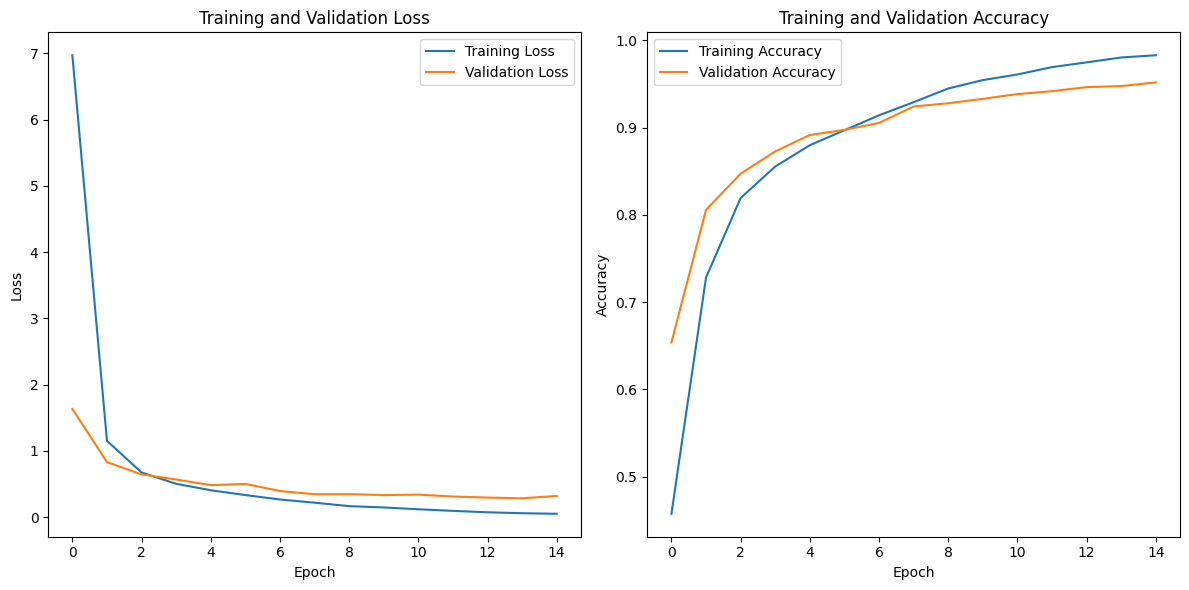

In [28]:
import matplotlib.pyplot as plt
# create a figure with two subplots

plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history_port.history['loss'], label = 'Training Loss')
plt.plot(history_port.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history_port.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_port.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# display the plot

plt.tight_layout()
plt.show()

38/38 [==============================] - 5s 118ms/step - loss: 0.3314 - accuracy: 0.9464
Test accuracy: 0.9464359283447266


2024-08-05 00:05:35.869420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


38/38 [==============================] - 5s 110ms/step
              precision    recall  f1-score   support

           A       0.94      0.98      0.96        81
           B       0.97      0.96      0.96        68
           C       0.93      0.94      0.94        90
           D       0.97      1.00      0.98        83
           E       0.97      0.93      0.95        92
           F       0.91      0.98      0.95        98
           G       0.92      0.90      0.91        78
           H       0.96      0.92      0.94        95
           I       0.93      0.88      0.90        73
           J       0.85      0.94      0.89        77
           K       0.93      0.95      0.94       112
           L       0.96      0.98      0.97        97
           M       0.94      0.97      0.96        79
           N       0.97      0.90      0.93        70
           O       0.92      0.98      0.95        94
           P       0.98      0.90      0.94       122
           Q       0.97   

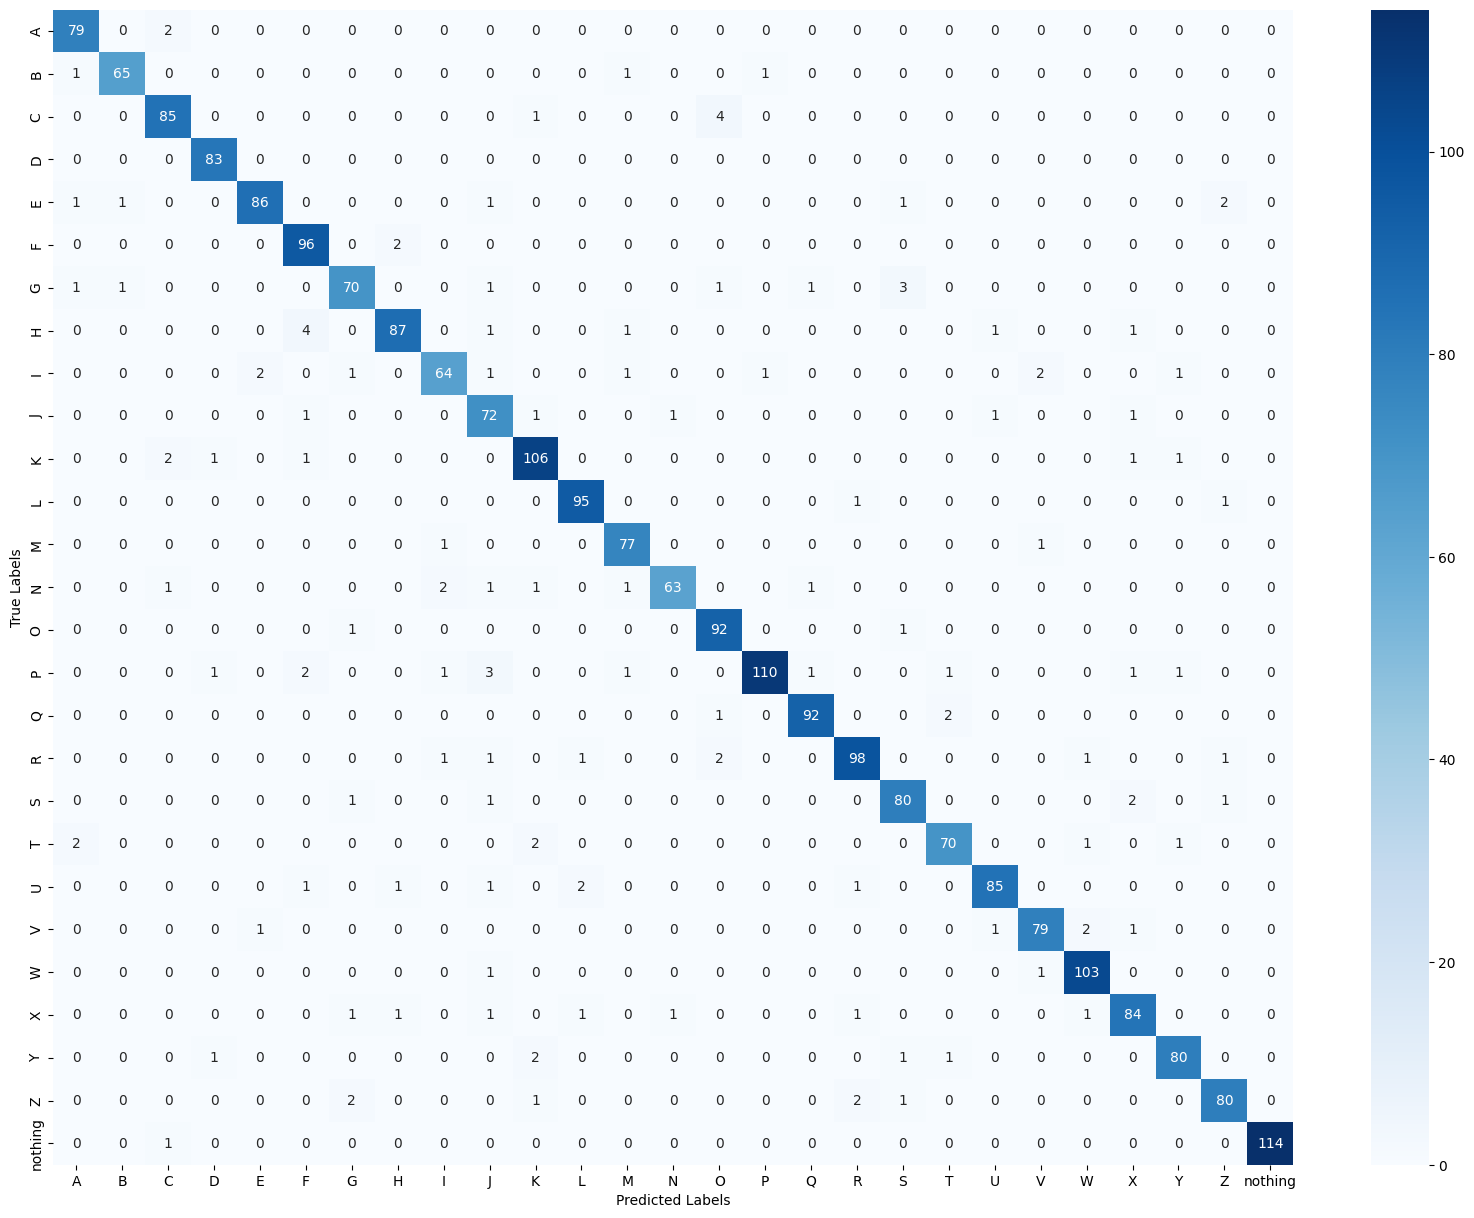

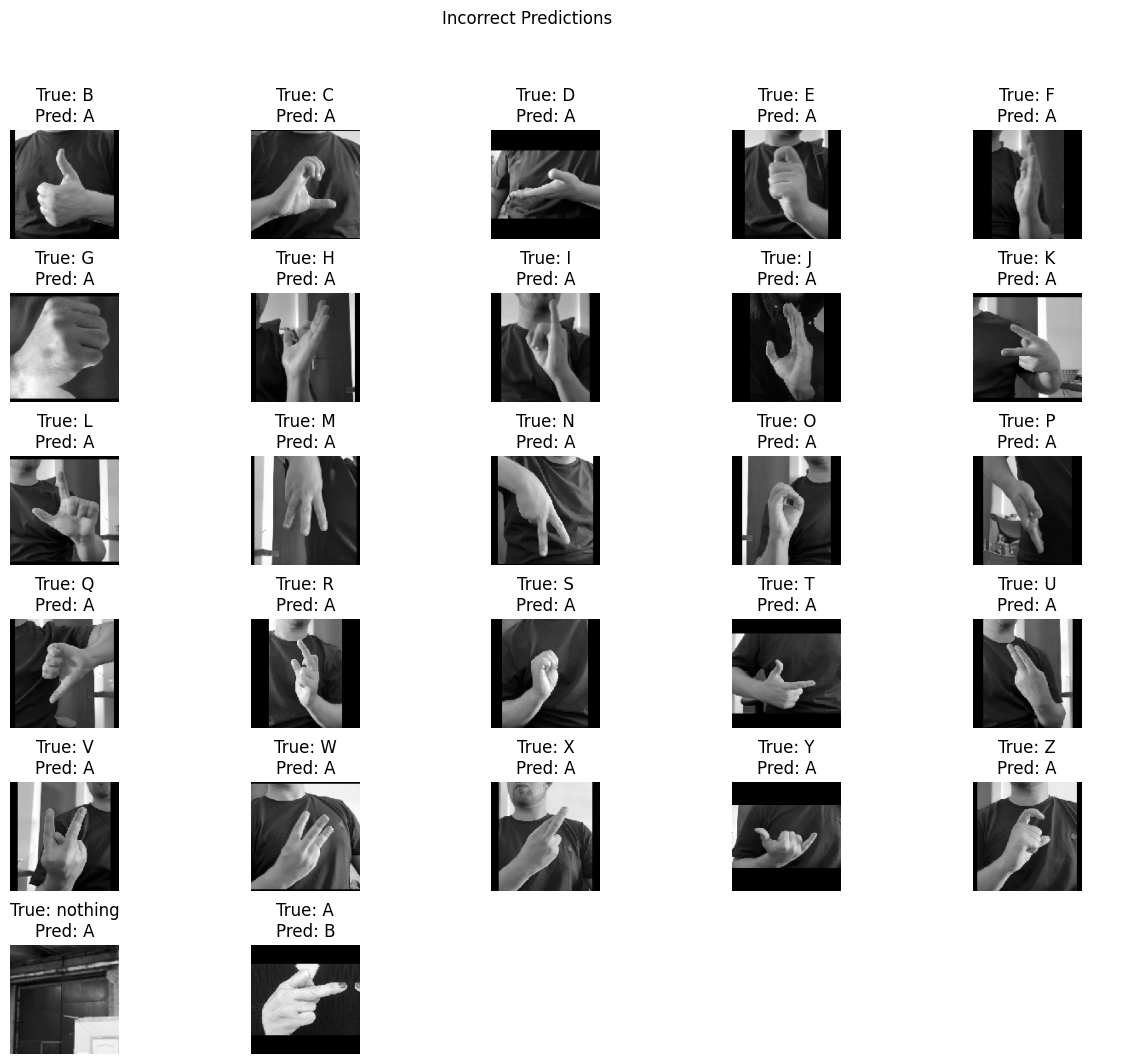

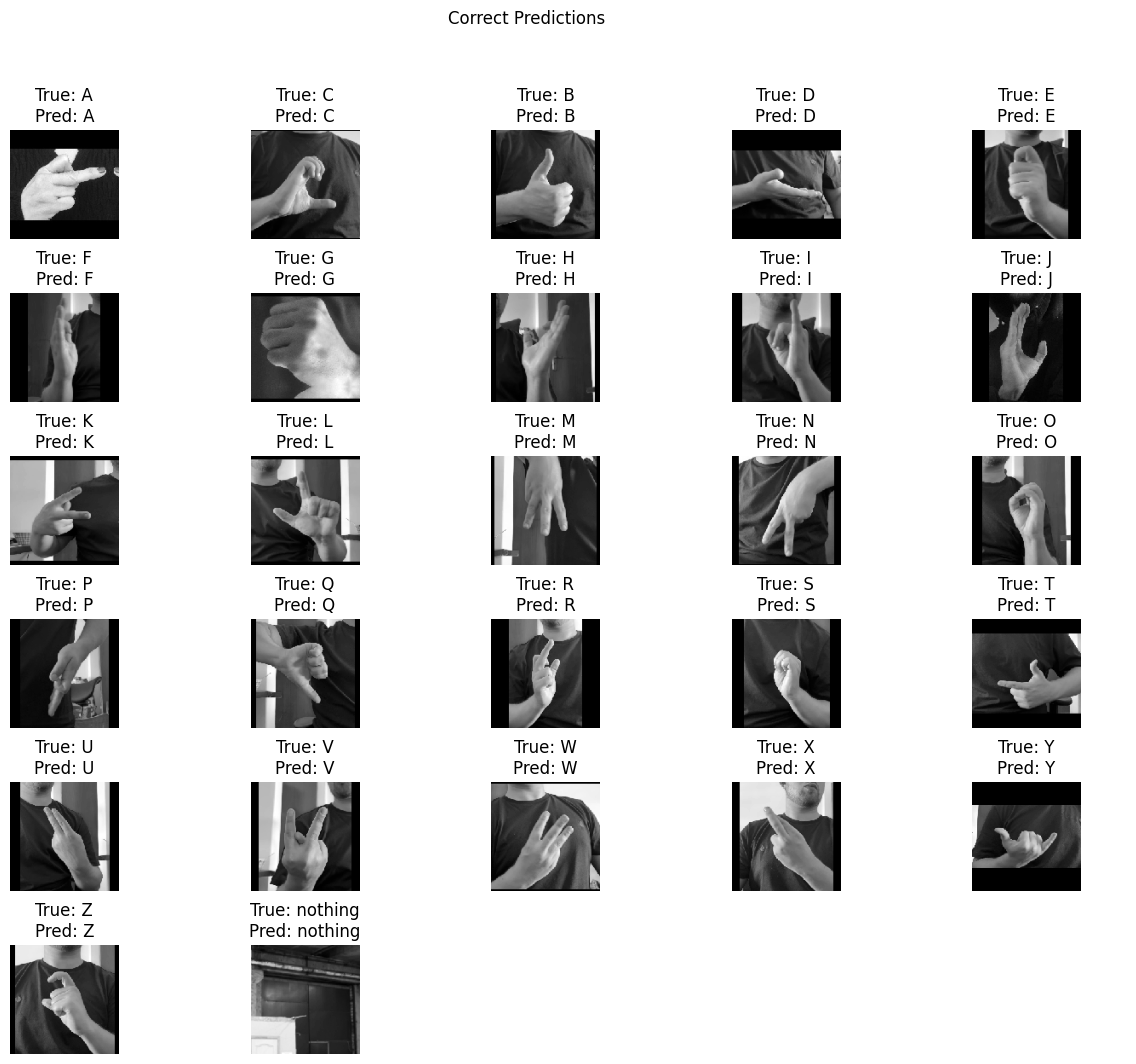

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model
loss, accuracy = model2.evaluate(test_generator2)
print(f'Test accuracy: {accuracy}')

# Make predictions
test_generator2.reset()
y_pred = model2.predict(test_generator2, steps=test_generator2.samples // test_generator2.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator2.classes

# Classification report
class_labels = list(test_generator2.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Plot confusion matrix
plt.figure(figsize=(20,15))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Collect one incorrect and one correct example per class
incorrect_examples = {}
correct_examples = {}

# Reset the test generator
test_generator2.reset()

for i in range(len(y_true)):
    img, label = test_generator2.next()
    true_label = np.argmax(label)
    pred_label = y_pred_classes[i]
    
    if true_label != pred_label and true_label not in incorrect_examples:
        incorrect_examples[true_label] = (img[0], class_labels[true_label], class_labels[pred_label])
    if true_label == pred_label and true_label not in correct_examples:
        correct_examples[true_label] = (img[0], class_labels[true_label], class_labels[pred_label])
        
    if len(incorrect_examples) == num_classes and len(correct_examples) == num_classes:
        break

# Plot incorrect predictions
fig, axes = plt.subplots(len(incorrect_examples) // 5 + 1, 5, figsize=(15, 12))
axes = axes.ravel()

for i, (key, value) in enumerate(incorrect_examples.items()):
    img, true_label, pred_label = value
    axes[i].imshow(img.reshape(128, 128), cmap='gray')
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Incorrect Predictions')
plt.show()

# Plot correct predictions
fig, axes = plt.subplots(len(correct_examples) // 5 + 1, 5, figsize=(15, 12))
axes = axes.ravel()

for i, (key, value) in enumerate(correct_examples.items()):
    img, true_label, pred_label = value
    axes[i].imshow(img.reshape(128, 128), cmap='gray')
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Correct Predictions')
plt.show()

In [35]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #optimization
tflite_quant_model = converter.convert()

# Save the model.
with open('model_final_pt.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/70/kmnvdzn900s0c5pywngxnj0r0000gn/T/tmpx501rxoc/assets


INFO:tensorflow:Assets written to: /var/folders/70/kmnvdzn900s0c5pywngxnj0r0000gn/T/tmpx501rxoc/assets
2024-08-05 16:12:27.534218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-08-05 16:12:27.534464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 13, Total Ops 36, % non-converted = 36.11 %
 * 13 ARITH ops

- arith.constant:   13 occurrences  (f32: 12, i32: 1)



  (f32: 3)
  (f32: 3)
  (f32: 2)
  (f32: 3)
  (f32: 3)
  (uq_8: 4)
  (f32: 1)
  (f32: 1)


In [26]:
import dill
import pickle

# Variables to save
variables_to_save = {
    'num_classes': num_classes,
    'input_shape': input_shape,
    'class_labels': labels,
    'history4': history_port.history  # Assuming you want to save the history
}

# Save the variables
with open('variables_pt.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)



In [ ]:
dill.dump_session('notebook_session_excluding_generators.pkl', main=True)